In [4]:
import os 
import random
import torch
import numpy as np
import PIL
import cv2
import time
from pynput.mouse import Button, Controller
from pynput.keyboard import Listener, KeyCode, Key
import onnx
import onnxruntime as ort
import matplotlib.pyplot as plt
import pygame
import dxcam
import threading

pygame 2.1.2 (SDL 2.0.18, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
function_keys = [("f1",Key.f1), 
                 ("f2",Key.f2), 
                 ("f3",Key.f3), 
                 ("f4",Key.f4), 
                 ("f5",Key.f5), 
                 ("f6",Key.f6), 
                 ("f7",Key.f7), 
                 ("f8",Key.f8), 
                 ("f9",Key.f9), 
                 ("f10",Key.f10), 
                 ("f11",Key.f11), 
                 ("f12",Key.f12)]


selected_toggle_key = "f9"


TOGGLE_KEY = KeyCode(char=selected_toggle_key)  

for i in function_keys:
    if selected_toggle_key == i[0]:
        TOGGLE_KEY = i[1]
        
    
    
clicking = False

mouse = Controller()

def clicker():
    while True:
        if clicking:
            mouse.click(Button.left,1)
        time.sleep(0.001)
        
def toggle_event(key):
    if key == TOGGLE_KEY:
        global clicking
        clicking = not clicking
        
click_thread = threading.Thread(target=clicker,daemon=True)
click_thread.start()


with Listener(on_press = toggle_event) as listener:
    listener.join()



# listener = Listener(on_press=toggle_event)
# listener.start()

while True:
    pass

In [179]:
def getFrame(width=640,height=640,verbose=False):
    
    total_time = time.time()
    frame_array = camera.get_latest_frame()
    
    frame = PIL.Image.fromarray(frame_array)

    resized = frame.resize((width,height))
    resized = np.array(resized).astype(np.float32) # Converting to the expected float 32 input
    resized = np.expand_dims(resized.transpose(2,0,1),0) # Setting dimensions to (1,3,640,640)
    resized /= 255 # Normalizing values 
    
    if verbose:
        print(time.time() - total_time)
    
    return frame_array,resized

In [3]:
onnx_model = onnx.load("model.onnx")
onnx.checker.check_model("model.onnx")
ort_sess = ort.InferenceSession('model.onnx', providers=['CUDAExecutionProvider'])

In [ ]:
# Initializing variables

camera = dxcam.create(device_idx=0, output_idx=0)

original_res = np.array(camera.grab()).shape

image_width = 640
image_height = 640

window_width = 1280
window_height = 720

classes_dict = {0: 'GoldenCartridge',
           1: 'GoldenCookie',
           2: 'RedCartridge',
           3: 'RedCookie'}

classes_color_dict = {0: (100,255,0), #Green
           1: (100,255,0), #Green
           2: (255,0,220), #Pink
           3: (255,0,220)} #Pink

font = cv2.FONT_HERSHEY_SIMPLEX

camera.start(target_fps=40)

has_detected = False

# Creating clicker thread 
TOGGLE_KEY = KeyCode(char="t") # Select the toogle key that activates autoclicking
clicking = False

mouse = Controller()

def clicker():
    while True:
        if clicking:
            mouse.click(Button.left,1)
        time.sleep(0.001)
        
def toggle_event(key):
    if key == TOGGLE_KEY:
        global clicking
        clicking = not clicking
        
click_thread = threading.Thread(target=clicker, daemon=True) # A Daemon thread kills it when the main thread ends 
click_thread.start()

# Start the loop

with Listener(on_press = toggle_event) as listener: # Starting the listener thread
    while True:

        total_iter_time = time.time()

        pygame_init_time = time.time()
        pygame.init()
        surface = pygame.display.set_mode((window_width,window_height))
        pygame.display.set_caption("Image")
        pygame_init_time = time.time() - pygame_init_time

        get_screenshoot_time = time.time()
        original,resized = getFrame(image_width, image_height)
        get_screenshoot_time = time.time() - get_screenshoot_time 


        inference_time = time.time()
        outputs = ort_sess.run(None, {'images': resized})
        inference_time = time.time() - inference_time


        img = cv2.cvtColor(original, cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, (window_width,window_height))


        print_time = time.time()
        if len(outputs[0]) > 0:
            x1_all = []
            y1_all = []
            x2_all = []
            y2_all = []
            classes_all = []
            confidences = []

            for i in range(len(outputs[0])):
                x1_all.append(outputs[0][i][1] * window_width / image_width)
                y1_all.append(outputs[0][i][2] * window_height / image_height)
                x2_all.append(outputs[0][i][3] * window_width / image_width)
                y2_all.append(outputs[0][i][4] * window_height / image_height)
                classes_all.append(int(outputs[0][i][5]))
                confidences.append(round(outputs[0][i][6],2))



            for x1,y1,x2,y2,classes,confidence in zip(x1_all,y1_all,x2_all,y2_all,classes_all,confidences):
                cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), classes_color_dict[classes])
                cv2.putText(img,classes_dict[classes] + ": " + str(confidence),(int(x1),int(y1)-8), 
                            font, 0.6,classes_color_dict[classes],2,cv2.LINE_AA)


            x1 = original_res[1] * x1_all[0] / window_width
            x2 = original_res[1] * x2_all[0] / window_width
            y1 = original_res[0] * y1_all[0] / window_height
            y2 = original_res[0] * y2_all[0] / window_height

            #mouse.position = ((x1+x2)/2, (y1+y2)/2)
            has_detected = True

        elif has_detected:
            #mouse.position = (385, 570) # Back to the main cookie
            has_detected = False


        displayImage = pygame.image.frombuffer(img.tobytes(), img.shape[1::-1],"BGR")
        surface.blit(displayImage,(0,0))
        pygame.display.update()
        print_time = time.time() - print_time

        total_iter_time = time.time() - total_iter_time

## Auto Farm

### Template matching

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os 

def template_matching(img,template,threshold=0,verbose=True,RGB=False):
    
    img = img.copy()
    if RGB:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        

    #read height and width of template image
    w, h = template.shape[1], template.shape[0]

    template_match = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)
    
    if threshold > 0 and threshold <= 1:
        loc = np.where( template_match >= threshold)

        center_coords = []
        for pt in zip(*loc[::-1]):
            cv2.rectangle(img, pt, (pt[0] + w, pt[1] + h), (0,255,0), 2)
            coord = ((pt[0] + pt[0] + w) // 2,(pt[1] + pt[1] + h) // 2)
            if verbose:
                print("Center coords: ",coord)
            center_coords.append(coord)
        center_coords.reverse()
        
        if len(center_coords) == 1:
            center_coords = center_coords[0] # Unleashing the list

        if verbose:
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
    else:
        pt = list(zip(*np.where(template_match == np.amax(template_match))[::-1]))[0]
        if verbose:
            print("Max similarity value:",np.amax(template_match))
        cv2.rectangle(img, pt, (pt[0] + w, pt[1] + h), (0,255,0), 2)

        center_coords = ((pt[0] + pt[0] + w) // 2,(pt[1] + pt[1] + h) // 2)

        if verbose:
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            print("Center coords: ",center_coords)
        
    return center_coords

In [2]:
import dxcam
from pynput.mouse import Button, Controller
from pynput.keyboard import Listener, KeyCode, Key

camera = dxcam.create(device_idx=0, output_idx=0)
camera.start()

mouse = Controller()

#### Big cookie finder

Max similarity value: 0.35962626
Center coords:  (2134, 1344)


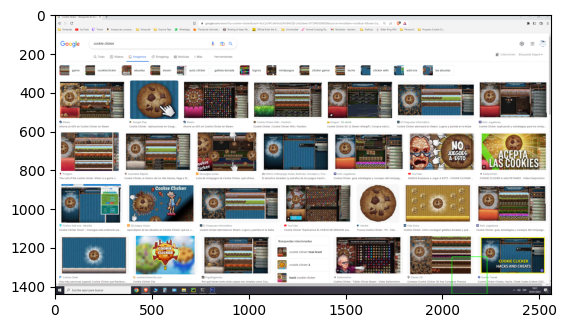

In [24]:
#load image into variable
img = cv2.imread('Cookie_Cliker_Dataset/Cookie Clicker Raw Dataset/cookie80.png')

#load template
template = cv2.imread('Template_Matching_Imgs/1440p/Big_cookie.png')

img = camera.get_latest_frame()

mouse.position = template_matching(img,template,RGB=True)

In [52]:
img = camera.grab()

#### Silent parcel finder

Center coords:  (2006, 517)


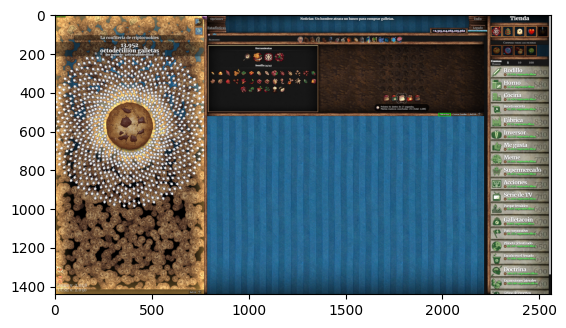

In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os 



#load image into variable
img = cv2.imread('Template_Matching_Imgs/multiple_parcels_fullscreen1440.PNG')

#load template
template = cv2.imread('Template_Matching_Imgs/Silent_parcel.png')

img = camera.get_latest_frame()

mouse.position = template_matching(img,template,RGB=True,threshold=0.9)

#### Close garden finder

Center coords:  (2085, 517)


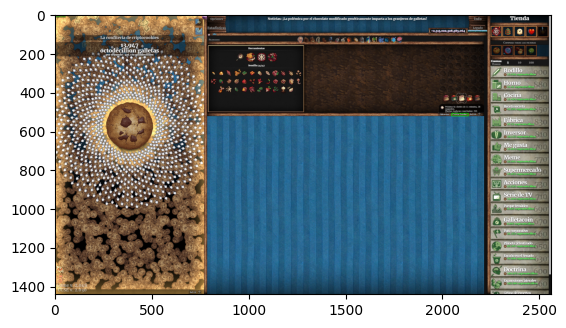

In [11]:
#load image into variable
img = cv2.imread('Cookie_Cliker_Dataset/Cookie Clicker Raw Dataset/cookie98.png')

#load template
template = cv2.imread('Template_Matching_Imgs/Close_garden.png')


img = camera.get_latest_frame()

mouse.position = template_matching(img,template,RGB=True,threshold=0.9)

#### Farm icon finder

Center coords:  (1375, 129)


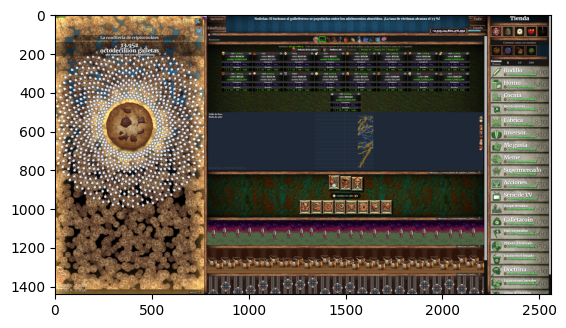

In [70]:
#load image into variable
img = cv2.imread('Cookie_Cliker_Dataset/Cookie Clicker Raw Dataset/cookie1.png')

#load template
template = cv2.imread('Template_Matching_Imgs/Farm_icon.png')


img = camera.get_latest_frame()

mouse.position = template_matching(img,template,RGB=True,threshold=0.9)

#### Individual garden holes finder

In [42]:
#load image into variable
#img = cv2.imread('Template_Matching_Imgs/Empty_garden_fullscreen1440.PNG')
img = cv2.imread('Cookie_Cliker_Dataset/Cookie Clicker Raw Dataset/cookie80.png')

#load template
holes_dirs = os.listdir("Template_Matching_Imgs/Garden_holes")

total_holes = len(holes_dirs)

coords = []
for hole in holes_dirs:
    template = cv2.imread('Template_Matching_Imgs/Garden_holes/' + hole)
    coords.append(template_matching(img,template,threshold=0.9,verbose=False))
    
coords = [x for x in coords if x] # Removing empty lists

print("Holes center coords: ",coords)
print("Detected holes:",len(coords),"out of",total_holes,"total")

Holes center coords:  [(1846, 347), (1885, 346), (1847, 388), (1887, 386)]
Detected holes: 4 out of 36 total


#### Empty garden finder

Center coords:  (1782, 288)


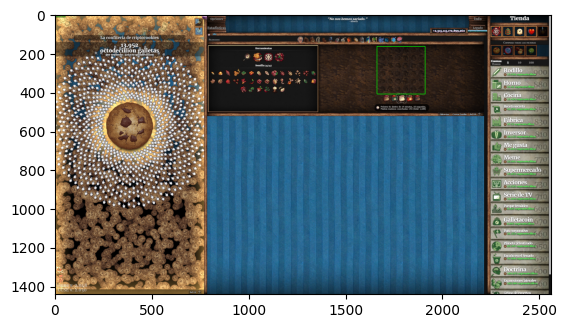

In [72]:
#load image into variable
img = cv2.imread('Template_Matching_Imgs/Empty_garden_fullscreen1440.PNG')

#load template
template = cv2.imread('Template_Matching_Imgs/Empty_garden_holes.PNG')


img = camera.get_latest_frame()

mouse.position = template_matching(img,template,RGB=True,threshold=0.9)

#### Remove crops icon finder

Center coords:  (1045, 224)


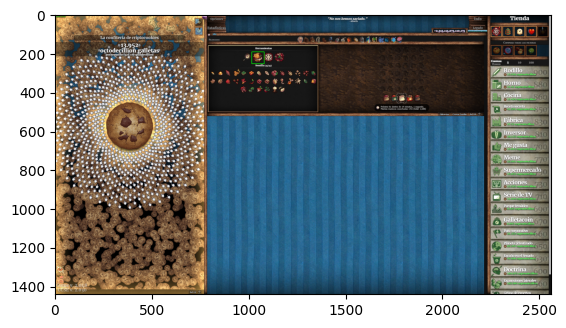

In [74]:
#load image into variable
img = cv2.imread('Template_Matching_Imgs/Empty_garden_fullscreen1440.PNG')

#load template
template = cv2.imread('Template_Matching_Imgs/crop_remover.PNG')

img = camera.get_latest_frame()

mouse.position = template_matching(img,template,RGB=True,threshold=0.9)

#### Target crop finder

Max similarity value: 1.0
Center coords:  (1012, 303)


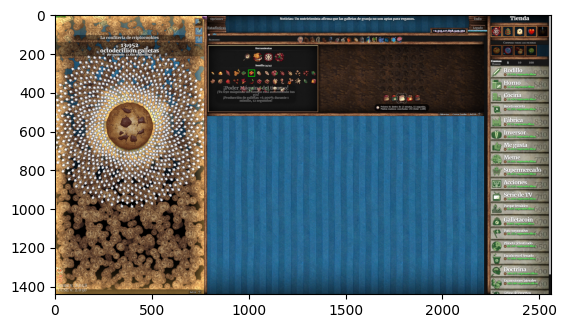

In [75]:
#load image into variable
img = cv2.imread('Template_Matching_Imgs/Empty_garden_fullscreen1440.PNG')

#load template
template = cv2.imread('Template_Matching_Imgs/target_seed.PNG')

img = camera.get_latest_frame()

mouse.position = template_matching(img,template,RGB=True)

#### Speed compost finder

Center coords:  (1746, 432)


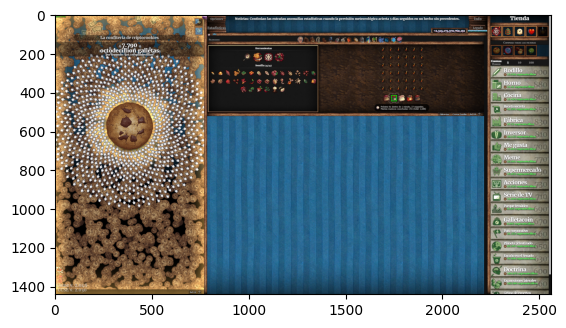

In [80]:
#load image into variable
img = cv2.imread('Template_Matching_Imgs/Empty_garden_fullscreen1440.PNG')

#load template
template = cv2.imread('Template_Matching_Imgs/Speed_compost.PNG')

img = camera.get_latest_frame()

mouse.position = template_matching(img,template,RGB=True,threshold=0.9)

#### Boost compost finder

Center coords:  (1786, 434)


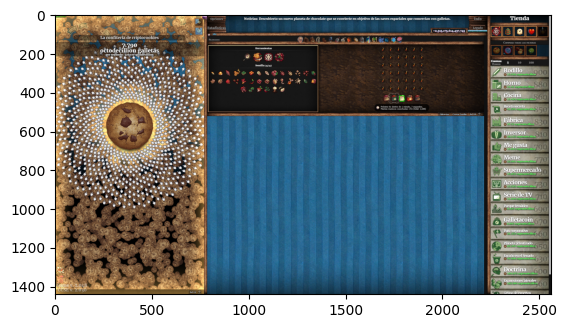

In [81]:
#load image into variable
img = cv2.imread('Template_Matching_Imgs/Empty_garden_fullscreen1440.PNG')

#load template
template = cv2.imread('Template_Matching_Imgs/Boost_compost.PNG')

img = camera.get_latest_frame()

mouse.position = template_matching(img,template,RGB=True,threshold=0.9)

In [39]:
def template_matching(img, template="Big_cookie", resolution=1440, threshold=-1, RGB=True, verbose=False):
    # img: Image to perform the template matching.
    # template: Selected template image.
    # resolution: resolution of the game (currently only 1440p is supported)
    # threshold: If float between 0 and 1 return the center coords of all the object detected with the selected or greater similarity level,
    #            if other number, return the center coords of the object with the maximum similarity value.
    # RGB: If true transforms the image to the BGR format which is the preferred one for opencv library.
    # verbose: If true prints the obtained center coords along with a plot of the image with the bounding boxes of the detected items.

    img = img.copy() # Creating a copy of the image
    img_with_bx = img.copy() # image with bounding boxes

    holes_dirs = ["empty"] # Initializing the variable in case Holes template is not selected

    # Selecting the template
    if resolution == 1080:
        template_path = 'Template_Matching_Imgs/1080p/'
    else:
        template_path = 'Template_Matching_Imgs/1440p/'

    if template == "Big_cookie":
        template = cv2.imread(template_path + "Big_cookie.png")
    elif template == "Silent_parcel":
        template = cv2.imread(template_path + "Silent_parcel.png")
    elif template == "Close_garden":
        template = cv2.imread(template_path + "Close_garden.png")
    elif template == "Farm_icon":
        template = cv2.imread(template_path + "Farm_icon.png")
    elif template == "Crop_remover":
        template = cv2.imread(template_path + "crop_remover.png")
    elif template == "Target_seed":
        template = cv2.imread(template_path + "target_seed.png")
    elif template == "Speed_compost":
        template = cv2.imread(template_path + "Speed_compost.png")
    elif template == "Boost_compost":
        template = cv2.imread(template_path + "Boost_compost.png")
    elif template == "Holes":
        template_path += "Garden_holes"
        holes_dirs = os.listdir(template_path) # This case is special and has its own pipeline
        total_holes = len(holes_dirs)

    else:
        template = template.copy() # If the input is an image keep it as it is

    coords = []
    for hole in holes_dirs:

        if hole != "empty":
            template = cv2.imread(template_path + "/" + hole)


        if RGB:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            img_with_bx = cv2.cvtColor(img_with_bx, cv2.COLOR_RGB2BGR)

        # read height and width of template image
        w, h = template.shape[1], template.shape[0]

        template_match = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)

        if threshold >= 0 and threshold <= 1:
            loc = np.where(template_match >= threshold)

            center_coords = []
            for pt in zip(*loc[::-1]):
                cv2.rectangle(img_with_bx, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)
                coord = ((pt[0] + pt[0] + w) // 2, (pt[1] + pt[1] + h) // 2)
                if verbose:
                    print("Center coords: ", coord)
                center_coords.append(coord)
            center_coords.reverse()

            if len(center_coords) == 1:
                center_coords = center_coords[0]  # Unleashing the list

        else:
            pt = list(zip(*np.where(template_match == np.amax(template_match))[::-1]))[0]
            if verbose:
                print("Max similarity value:", np.amax(template_match))
            cv2.rectangle(img_with_bx, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)

            center_coords = ((pt[0] + pt[0] + w) // 2, (pt[1] + pt[1] + h) // 2)

            coords.append(center_coords) # Only useful when looping through the holes templates
            
            if verbose:
                print("Center coords: ", center_coords)

    if verbose:
        img_with_bx = cv2.cvtColor(img_with_bx, cv2.COLOR_BGR2RGB)
        plt.imshow(img_with_bx)
                

    if hole != "empty":
        coords = [x for x in coords if x] # Removing empty lists
        return coords

    return center_coords

[]

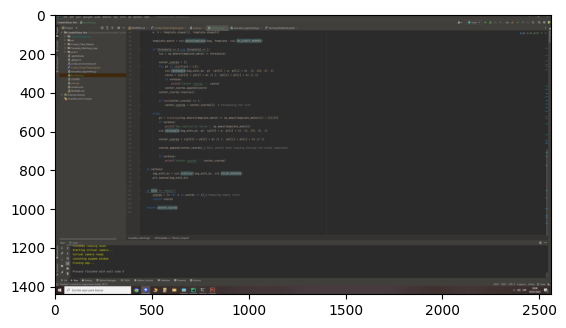

In [41]:

img = camera.get_latest_frame()
img = cv2.imread('Template_Matching_Imgs/1440p/Empty_garden_fullscreen1440.PNG')

coords = template_matching(img,template="Holes",threshold=0.9,RGB=False,verbose=True)
coords

### Auto plant

In [78]:
from pynput.mouse import Button, Controller
from pynput.keyboard import Listener, KeyCode, Key

mouse = Controller()
#mouse.position = (1280, 125) # Open farms
mouse.position = (2075, 510) # Close garden
mouse.click(Button.left, 1)
time.sleep(0.01)
mouse.position = (2075, 285) # Re-open garden
mouse.click(Button.left, 1)
time.sleep(0.01)

x,y = 1885,190 # Top right garden hole coords
for i in range(0,6):
    for j in range(0,6):
        mouse.position = (1005, 295) # Select golden trebol
        mouse.click(Button.left, 1)
        time.sleep(0.01)
        mouse.position = (x-i*40, y+j*40) # Travel through the garden holes
        mouse.click(Button.left, 1)
        time.sleep(0.01)
        
mouse.position = (1745, 425) # Change fertilizer
mouse.click(Button.left, 1)